<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Natural Language Processing: Classification
              
</p>
</div>

Data Science Cohort Live NYC July 2022
<p>Phase 4: Topic 39</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [75]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.pardir)
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import numpy as np
import pandas as pd

# importing text preprocessing libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer


In [77]:
# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

Build a very simple stateless transformer:
- Cleans/preprocesses text

In [78]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
        
        # save as parameters of Text preprocessor
        
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None


        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words)) ]

        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [79]:
data = pd.read_csv('Data/satire_nosatire.csv')
X = data['body']
y = data['target']

In [80]:
proc = TextPreprocessor()
proc.fit_transform(X)

0      note resignation james mattis secretary defens...
1      desperate unwind month nonstop work investigat...
2      nearly halfway presidential term donald trump ...
3      attempt make amends gross abuse power time int...
4      decry senate resolution blame crown prince bru...
                             ...                        
995    britain opposition leader jeremy corbyn push a...
996    turkey take fight islamic state militant syria...
997    malaysia seek reparation goldman sachs group i...
998    israeli court sentence palestinian year impris...
999    least people die due landslide flood trigger t...
Name: body, Length: 1000, dtype: object

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [82]:
prc_steps = [('token_norm', TextPreprocessor()), ('countvec', CountVectorizer(min_df = 0.05, max_df = 0.95))]
preprocess_pipeline = Pipeline(prc_steps)

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [84]:
X_tr_proc = preprocess_pipeline.fit_transform(X_train)

In [85]:
X_tr_proc

<700x614 sparse matrix of type '<class 'numpy.int64'>'
	with 45270 stored elements in Compressed Sparse Row format>

In [86]:
feat_names = preprocess_pipeline['countvec'].get_feature_names()

pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)

,able,accept,access,accord,account,accuse,act,action,actually,add,...,woman,word,work,worker,world,write,year,yes,yet,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1,1,0,0,0,0,0,1,1,0,0,...,0,0,0,2,0,2,2,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
696,0,0,0,0,1,0,1,0,0,2,...,0,0,1,0,1,3,1,0,0,0
697,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Building a document classifier model

**Naive Bayes with Multinomial Distribution Likelihood**

- Can be effective for modeling document-term frequency matrix to target class relationships

Bayes theorem:

$$ P(c|\textbf{x}) = \frac{P(\textbf{x}|c)P(c)}{P(\textbf{x})} $$

- Likelihood; $P(\textbf{x}|c)$
- Prior: $P(c)$
- Posterior: $P(c|\textbf{x}) $

Bayes classifier:
    
$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\max} P(\textbf{x}|c)P(c)$$

#### Prior
- simply the target fraction

In [87]:
class_priors = y_train.value_counts(normalize=True)#/y_train.shape[0]
class_priors

1    0.504286
0    0.495714
Name: target, dtype: float64

#### The likelihood function

**First step: word count distribution**:

- Multinomial distribution (generalization of 
binomial distribution)

For document with $m$ tokens:
- dictionary of corpus has $d$ unique tokens.
- $\textbf{x} = (x_1,...., x_d)$ vector of token counts for document.



An analogy: $d = 6$ M&M colors

Picking $ m $ M&Ms.

<img src = "Images/picking_candy.jpg" >
    
Follow multinomial distribution.


<a href = "https://www.mashed.com/679227/the-rarest-mm-color-may-surprise-you/#:~:text=Brown%20is%20currently%20the%20rarest%20color%20of%20M%26M's&text=As%20such%2C%20they%20used%20their,their%20findings%20were%20quite%20surprising."> Some interesting facts about M&Ms. </a>

$$ P(\textbf{x}|\theta) = \frac{m!}{x_1!x_2!...x_d!} \theta_{1}^{x_1}\theta_{2}^{x_2}...\theta_{d}^{x_d} $$
Parameters of distribution:
- $\theta_i$: probability of picking $i^{th}$ token  in dictionary from bag of words

**To be estimated from the data**

Words draws/order are **independent** of each other: the **naive** assumption.

<img src = "Images/scrabble.webp" />

#### Second Step: class conditional word count

$$ P(\textbf{x}|c) = \frac{m!}{x_1!x_2!...x_d!} [\theta_c]_{1}^{x_1}[\theta_c]_{2}^{x_2}...[\theta_c]_{d}^{x_d} $$
- $[\theta_c]$ is **class-dependent** set of probability parameters.

Need to fit probability parameters from data.

**Fitting probability parameters for each class**

- Very straightforward.
- Probability of drawing token $i$ if document class $c$

$$ [\hat{\theta}_c]_i = \frac{N_{ci}}{N_c}$$

- Count token $i$ occurence across all documents of class $c$
- Divide by total token count for all documents of class $c$

#### Getting the fit parameters with code

In [88]:
bow_mat = pd.DataFrame(X_tr_proc.toarray(), columns = feat_names)
bow_mat['target'] = y_train
bow_mat

,able,accept,access,accord,account,accuse,act,action,actually,add,...,woman,word,work,worker,world,write,year,yes,yet,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1,1,0,0,0,0,0,1,1,0,0,...,0,0,0,2,0,2,2,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
696,0,0,0,0,1,0,1,0,0,2,...,0,0,1,0,1,3,1,0,0,0
697,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
class1_bow_mat = bow_mat[bow_mat['target'] == 1].drop(columns = ['target'])

# class 1 token probabilities:
N_tok_1 = class1_bow_mat.sum(axis = 0) # token occurence
N_1 =  class1_bow_mat.values.sum() # number of tokens

# get probabilities for each token: class 1
proba_c1 = N_tok_1/N_1

proba_c1.sort_values(ascending = False)[0:10]

say           0.034145
year          0.009707
trump         0.009338
people        0.009281
state         0.008373
take          0.007578
make          0.007067
government    0.006812
president     0.006784
see           0.006698
dtype: float64

In [90]:
class0_bow_mat = bow_mat[bow_mat['target'] == 0].drop(columns = ['target'])

# class 1 token probabilities:
N_tok_0 = class0_bow_mat.sum(axis = 0)
N_0 =  class0_bow_mat.values.sum() 

# get probabilities for each token: class 0
proba_c0 = N_tok_0/N_0

proba_c0.sort_values(ascending = False)[0:10]

say           0.031878
people        0.008761
government    0.008098
year          0.007730
state         0.007509
time          0.007436
trump         0.007289
president     0.006626
make          0.006479
take          0.006258
dtype: float64

#### Computing likelihood

In [91]:
from scipy.stats import multinomial

Take document:

In [92]:
X_train.iloc[50]

' A group of U.S. activists opposed to President Donald Trump’s immigration policies helped migrants in Mexico during a clash with U.S. agents at the border on New Year’s Eve, and dispute their government’s account of the events. Late on Monday, about 150 migrants gathered at the border in Tijuana to try to enter the United States, according to the U.S. activists and a Reuters witness. After learning of a possible conflict, 11 U.S. volunteers who were in Tijuana headed to the border to provide medical assistance and document the events, said Lilith Sinclair, a spokeswoman for the group. The activists, some of whom are part of a group known as the Border Support Network, have said they were banding together to counter what they view as the U.S. government’s violation of asylum seekers’ rights. They have also challenged the U.S. government’s position that agents deployed tear gas after coming under attack. “This attack on migrants peacefully seeking asylum was crippling, inhumane and unp

In [93]:
# bow vector for document
bow_mat_feat = bow_mat.drop(columns = ['target'])
word_vec = bow_mat_feat.iloc[50]
word_vec

able       0
accept     0
access     2
accord     1
account    1
          ..
write      0
year       1
yes        0
yet        0
young      0
Name: 50, Length: 613, dtype: int64

This is satire.

In [94]:
y_train.iloc[50]

0

In [95]:
article_length = word_vec.sum()
article_length

192

In [96]:
class1_likelihood = multinomial.pmf(x = word_vec.values, n = article_length, p =  proba_c1.values)
class0_likelihood = multinomial.pmf(x = word_vec.values, n = article_length, p =  proba_c0.values)

Now use Bayes theorem for classifier:

$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\min} P(\textbf{x}|c)P(c)$$


with multinomial likelihood

$$ P(\textbf{x}|c) = \frac{m!}{x_1!x_2!...x_d!} [\hat{\theta}_c]_{1}^{x_1}[\hat{\theta}_c]_{2}^{x_2}...[\hat{\theta}_c]_{d}^{x_d} $$

and fitted parameters

$$ [\hat{\theta}_c]_i = \frac{N_{ci}}{N_c}$$

Evaluate class for this document:

$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\min} P(\textbf{x}|c)P(c)$$

In [97]:
class1_likelihood*class_priors[1]

1.1874946774489244e-190

In [98]:
class0_likelihood*class_priors[0]

1.0066150584687169e-193

Given scale of probabilities:
- Comparison done on log scale

$$f(\textbf{x}) = \hat{c} = \underset{c \in C}{\arg\max} \Big[ \log\Big(P(\textbf{x}|c)P(c)\Big) \Big]$$

In [99]:
np.log10(class1_likelihood*class_priors[1])

-189.92536832827972

In [100]:
np.log10(class0_likelihood*class_priors[0])

-192.99713657705735

#### Laplace Smoothing: practical correction

- A fudge count $\alpha$ added to token count in each class.
- Avoids issues with having zero counts.

$$ [\hat{\theta}_c]_i = \frac{N_{ci} + \alpha}{N_c + \alpha d}$$

- Typically $\alpha = 1$. Can tune this.

Append Multinomial Naive Bayes Classifier to pipeline.

In [101]:
from sklearn.naive_bayes import MultinomialNB

In [102]:
from copy import deepcopy
mod_pipe = deepcopy(preprocess_pipeline)
mod_pipe.steps.append(('multinb', MultinomialNB()))
mod_pipe.steps

[('token_norm', TextPreprocessor()),
 ('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
 ('multinb', MultinomialNB())]

In [103]:
mod_pipe.fit(X_train, y_train)

Pipeline(steps=[('token_norm', TextPreprocessor()),
                ('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('multinb', MultinomialNB())])

In [104]:
y_pred = mod_pipe.predict(X_test) # automatically applies transforms and predicts on test

In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       153
           1       0.96      0.95      0.96       147

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



In [106]:
roc_auc_score(y_test, y_pred)

0.9565826330532213

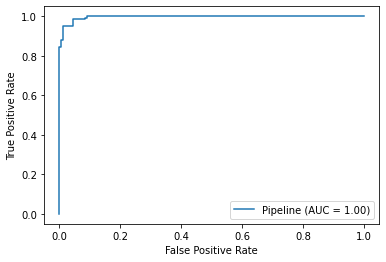

In [107]:
plot_roc_curve(mod_pipe, X_test, y_test)

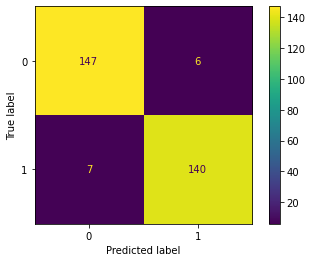

In [108]:
plot_confusion_matrix(mod_pipe, X_test, y_test)

- with proper text preprocessing steps
- Naive Bayes can perform really well on simple binary classification tasks.

#### Using TF-IDF

TFIDF does not necessarily perform better than CV:
- It is just a tool in our toolbelt often worth trying out.

In [109]:
from copy import deepcopy
tfidfmod_pipe = deepcopy(mod_pipe)
tfidfmod_pipe.steps[1] = ('tfidf', TfidfVectorizer(min_df=0.05, max_df=0.95)) # cuts words too rare/too frequent
tfidfmod_pipe.steps

[('token_norm', TextPreprocessor()),
 ('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
 ('multinb', MultinomialNB())]

In [110]:
tfidfmod_pipe.fit(X_train, y_train)
ypred_tfidf = tfidfmod_pipe.predict(X_test)

In [111]:
roc_auc_score(y_test, ypred_tfidf)

0.9701880752300921

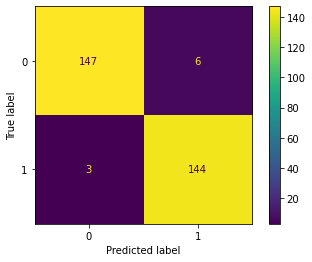

In [112]:
plot_confusion_matrix(tfidfmod_pipe, X_test, y_test)

#### With class imbalance

- Modification to Multinomial Naive Bayes: Complement Naive Bayes
- deals with data skew.

In [113]:
from sklearn.naive_bayes import ComplementNB

Pretty much same fitting/hyperparameters.

In [114]:
from copy import deepcopy
mod_comp_pipe = deepcopy(preprocess_pipeline)
mod_comp_pipe.steps.append(('compnb', ComplementNB()))
mod_comp_pipe.steps

[('token_norm', TextPreprocessor()),
 ('countvec', CountVectorizer(max_df=0.95, min_df=0.05)),
 ('compnb', ComplementNB())]

In [115]:
mod_comp_pipe.fit(X_train, y_train)
y_pred_comp = mod_comp_pipe.predict(X_test)

In [116]:
print(classification_report(y_pred_comp, y_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       155
           1       0.95      0.97      0.96       145

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



Comparable performance on this balanced dataset. Will perform *much* better on imbalanced dataset than MultinomialNB